# Simple Toy TS Training for Deep3D+

In [1]:
"""
Simple tester for the deep3d
"""
import tensorflow as tf
import Deep3D_vggfixed_bn as deep3d
import utils
import numpy as np
import os
import os.path
import h5py

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Importing Data from H5 Format for fast loading
- Will eventually unit test dynamic CPU data loading pipeline here

In [4]:
inria_file = '/a/data/deep3d_data/inria_data.h5'
# inria_file = 'data/inria_data.h5'
h5f = h5py.File(inria_file,'r')

X_train_0 = h5f['X_0'][:,10:170,16:304,:]
Y_train_0 = h5f['Y_0'][:,10:170,16:304,:]
X_train_1 = h5f['X_1'][:,10:170,16:304,:]
Y_train_1 = h5f['Y_1'][:,10:170,16:304,:]
X_train_2 = h5f['X_2'][:,10:170,16:304,:]
Y_train_2 = h5f['Y_2'][:,10:170,16:304,:]
X_train_3 = h5f['X_3'][:,10:170,16:304,:]
Y_train_3 = h5f['Y_3'][:,10:170,16:304,:]
X_train_4 = h5f['X_4'][:,10:170,16:304,:]
Y_train_4 = h5f['Y_4'][:,10:170,16:304,:]
X_train_5 = h5f['X_5'][:,10:170,16:304,:]
Y_train_5 = h5f['Y_5'][:,10:170,16:304,:]
X_train_6 = h5f['X_6'][:,10:170,16:304,:]
Y_train_6 = h5f['Y_6'][:,10:170,16:304,:]
X_train_7 = h5f['X_7'][:,10:170,16:304,:]
Y_train_7 = h5f['Y_7'][:,10:170,16:304,:]


X_val = h5f['X_4'][:,10:170,16:304,:]
Y_val = h5f['Y_4'][:,10:170,16:304,:]
  
h5f.close()

In [5]:
X_train = np.concatenate([X_train_0,X_train_1,X_train_2,X_train_3,X_train_4,X_train_5,X_train_6,X_train_7])
Y_train = np.concatenate([Y_train_0,Y_train_1,Y_train_2,Y_train_3,Y_train_4,Y_train_5,Y_train_6,Y_train_7])

print "Training Size:" + str(X_train.shape)
print "Validation Size:" + str(X_val.shape)

Training Size:(3943, 160, 288, 3)
Validation Size:(500, 160, 288, 3)


## Training Loop

In [6]:
batchsize = 50
num_epochs = 5
num_batches = (X_train.shape[0]/batchsize)*num_epochs
print_step = 1
viz_step = 10

# Define config for GPU memory debugging 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True  # Switch to True for dynamic memory allocation instead of TF hogging BS
config.gpu_options.per_process_gpu_memory_fraction= 1  # Cap TF mem usage
config.allow_soft_placement=True
with tf.device('/gpu:0'):
    # Session
    sess = tf.Session(config=config)
    
    # Placeholders
    batch_size_ph = tf.placeholder(dtype=tf.int32)
    images = tf.placeholder(tf.float32, [None, 160, 288, 3], name='input_batch')
    true_out = tf.placeholder(tf.float32, [None, 160, 288, 3] , name='ground_truth')
    train_mode = tf.placeholder(tf.bool, name='train_mode')

    # Building Net based on VGG weights 
    net = deep3d.Deep3Dnet('./vgg19.npy', dropout = 0.7)
    net.build(images, train_mode)

    # Print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    print 'Variable count:'
    print(net.get_var_count())
    
    # Run initializer 
    sess.run(tf.global_variables_initializer())
   
    # Define Training Objectives
    cost = tf.reduce_sum(tf.abs(net.prob - true_out), name='L1_loss')
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):    
        train = tf.train.GradientDescentOptimizer(0.002).minimize(cost)
        
    # Track Cost    
    tf.summary.scalar('cost', cost)
    # tensorboard operations to compile summary and then write into logs
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./tensorboard_logs/', graph = sess.graph)

    
    # Training Loop
    print ""
    print "== Start training =="
    for i in xrange(num_batches):
        # Creating Batch
        image_mask = np.random.choice(X_train.shape[0],batchsize)
        images_in = X_train[image_mask,:,:,:]
        labels_in = Y_train[image_mask,:,:,:]

        # Traing Step
        _, cost_val, summary = sess.run([train, cost, merged], feed_dict={images: images_in, true_out: labels_in, train_mode: True})
        writer.add_summary(summary, i)

        # No longer needed: cost_hist.append(cost_val)
        if i%print_step == 0:
            print ("({}/{})".format(i, num_batches).ljust(10) + ' | Cost: ' + str(cost_val))
    
    
    print ""
    print "Training Completed, storing weights"
    # Store Traing Output
    net.save_npy(sess)
    

Variable count:
138408071

== Start training ==
(0/390)    | Cost: 516591.0
(1/390)    | Cost: 414176.0
(2/390)    | Cost: 398897.0
(3/390)    | Cost: 372072.0
(4/390)    | Cost: 427848.0
(5/390)    | Cost: 421958.0
(6/390)    | Cost: 404954.0
(7/390)    | Cost: 446639.0
(8/390)    | Cost: 431615.0
(9/390)    | Cost: 423288.0
(10/390)   | Cost: 405081.0
(11/390)   | Cost: 418749.0
(12/390)   | Cost: 455614.0
(13/390)   | Cost: 458031.0
(14/390)   | Cost: 422611.0
(15/390)   | Cost: 405650.0
(16/390)   | Cost: 372928.0
(17/390)   | Cost: 410730.0
(18/390)   | Cost: 422269.0
(19/390)   | Cost: 407863.0
(20/390)   | Cost: 387554.0
(21/390)   | Cost: 385863.0
(22/390)   | Cost: 406410.0
(23/390)   | Cost: 435536.0
(24/390)   | Cost: 379798.0
(25/390)   | Cost: 409447.0
(26/390)   | Cost: 414832.0
(27/390)   | Cost: 427906.0
(28/390)   | Cost: 393702.0
(29/390)   | Cost: 440778.0
(30/390)   | Cost: 424660.0
(31/390)   | Cost: 438997.0
(32/390)   | Cost: 478896.0
(33/390)   | Cost: 418987.0


(291/390)  | Cost: 415360.0
(292/390)  | Cost: 426116.0
(293/390)  | Cost: 412812.0
(294/390)  | Cost: 416322.0
(295/390)  | Cost: 438414.0
(296/390)  | Cost: 445407.0
(297/390)  | Cost: 451960.0
(298/390)  | Cost: 454063.0
(299/390)  | Cost: 433080.0
(300/390)  | Cost: 389342.0
(301/390)  | Cost: 414159.0
(302/390)  | Cost: 400472.0
(303/390)  | Cost: 419409.0
(304/390)  | Cost: 423984.0
(305/390)  | Cost: 394054.0
(306/390)  | Cost: 370489.0
(307/390)  | Cost: 464530.0
(308/390)  | Cost: 427064.0
(309/390)  | Cost: 422431.0
(310/390)  | Cost: 445384.0
(311/390)  | Cost: 441981.0
(312/390)  | Cost: 413465.0
(313/390)  | Cost: 419971.0
(314/390)  | Cost: 419914.0
(315/390)  | Cost: 444398.0
(316/390)  | Cost: 429942.0
(317/390)  | Cost: 398168.0
(318/390)  | Cost: 424679.0
(319/390)  | Cost: 411745.0
(320/390)  | Cost: 414870.0
(321/390)  | Cost: 427763.0
(322/390)  | Cost: 393991.0
(323/390)  | Cost: 434188.0
(324/390)  | Cost: 394692.0
(325/390)  | Cost: 461667.0
(326/390)  | Cost: 3

## Testing Output

In [17]:
# Test
test_img = np.expand_dims(X_val[200], axis = 0)
test_ans = Y_val[200]

with tf.device("/gpu:0"):
    res, mask, up_conv = sess.run([net.prob, net.mask, net.up_conv], 
                                  feed_dict={images: test_img, train_mode: False})

--- Input ---


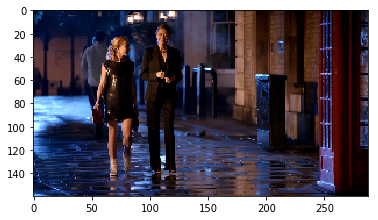

--- GT ---


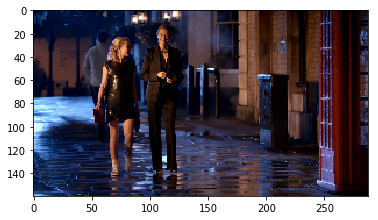

--- Our result ---


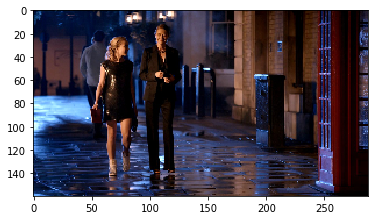

In [18]:
import matplotlib.pyplot as plt
print "--- Input ---"
plt.imshow(test_img[0])
plt.show()

print "--- GT ---"
plt.imshow(test_ans)
plt.show()

print "--- Our result ---"
plt.imshow(res[0])
plt.show()

#pyplot.imsave('1.jpeg', test_img[0])
#pyplot.imsave('2.jpeg', res[0])

## Looking at Disparity Maps

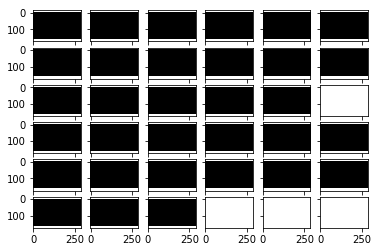

In [19]:
f, axs = plt.subplots(6, 6, sharex='col', sharey='row')

for i in range(33):
    axs[i/6][i%6].imshow(mask[0,:,:,i],cmap="gray",vmin=0.0, vmax=1.0)
plt.show()

In [20]:
max_shift_channel = np.argmax(mask,axis = 3)
max_shift_channel[0]

array([[17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17],
       ..., 
       [17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17],
       [17, 17, 17, ..., 17, 17, 17]])

In [21]:
channel_mean = np.mean(mask[0], axis =(0,1))
channel_mean

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

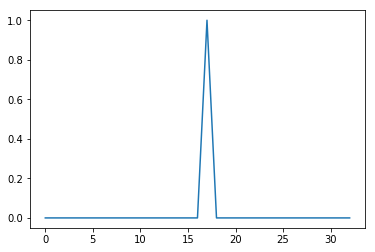

In [22]:
plt.plot(channel_mean)
plt.show()

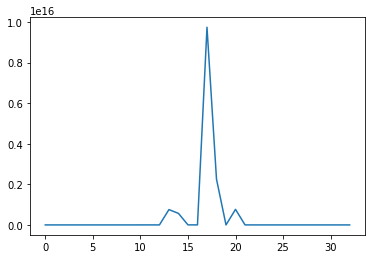

In [23]:
channel_act_mean = np.mean(up_conv[0], axis =(0,1))
plt.plot(channel_act_mean)
plt.show()

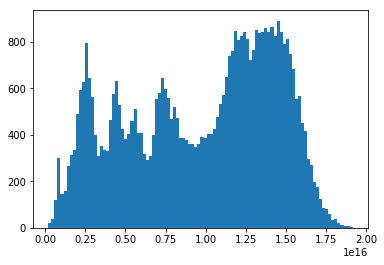

In [26]:
plt.hist(up_conv[0,:,:,17].ravel(), bins=100)
plt.show()

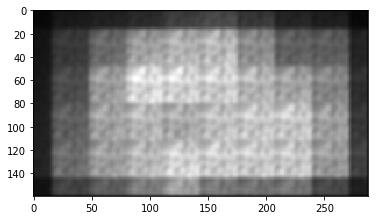

In [28]:
plt.imshow(up_conv[0,:,:,17],cmap="gray")
plt.show()